In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
import warnings
from sklearn.cluster import KMeans
from kneed import KneeLocator
import collections

In [2]:
###################################################################
## Read data
###################################################################

data = pd.read_csv("./data_house/database.csv", sep = ',') 
column_names = data.columns
n = len(data.columns)
print("Dataset shape:", data.shape)

# Normalize data
data_normal = pd.DataFrame(StandardScaler().fit_transform(data), columns = column_names)

Dataset shape: (10000, 13)


In [3]:
###################################################################
## Functions
###################################################################

def sort_by_indexes(lst, indexes, reverse=False):
  return [val for (_, val) in sorted(zip(indexes, lst), key=lambda x: \
          x[0], reverse=reverse)]

def jaccard_similarity(A, B):
    
    #Find intersection
    nominator = intersection(A,B)
    #print(nominator)
    #Find union 
    denominator = union(A,B)
    #print(denominator)
    #Take the ratio of sizes
    similarity = len(nominator)/len(denominator)
    
    
    #print(similarity)
    return similarity

def intersection(lst1, lst2):
    lst3 = []
    for value in lst1:
        if ((value in lst2) & (len(lst2) > 0)):
            lst3.append(str(value))
            lst2.remove(value)
    return lst3

def union(lst1, lst2):
    lst3 = lst1 + lst2 
    return lst3

In [4]:
###################################################################
## Dimensionality reduction
###################################################################

pca = PCA(n_components = 0.70)
data = pca.fit_transform(data_normal)
data = pd.DataFrame(data)
print(data.shape)

(10000, 9)



-----------------DBSCAN--------------

Labels for DBSCAN:  [-1  0]
n_clusters for DBSCAN:  1


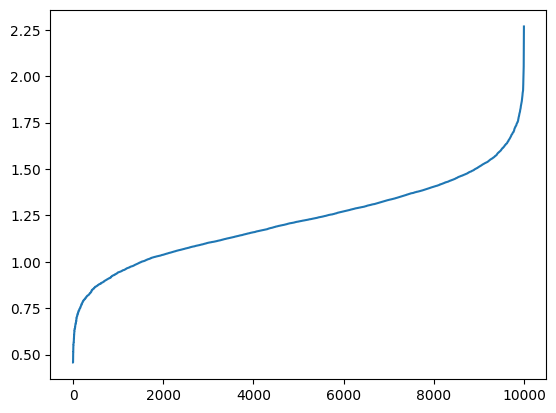

In [5]:

###################################################################
## Find parameters of DBSCAN
###################################################################

neighb = NearestNeighbors(n_neighbors=n) 
nbrs=neighb.fit(data) # fitting the data to the object
distances,indices=nbrs.kneighbors(data) # finding the nearest neighbours

# Sort and plot the distances results
plt.figure()
distances = np.sort(distances, axis = 0) # sorting the distances
distances = distances[:, 1] # taking the second column of the sorted distances
plt.rcParams['figure.figsize'] = (5,3) # setting the figure size
plt.plot(distances) # plotting the distances
plt.savefig('./data_house/figure_pre_dbsacn') # showing the plot


###################################################################
## DBSCAN
###################################################################
# clusters
print('\n-----------------DBSCAN--------------\n')
dbscan = DBSCAN(eps = 1.75, min_samples = 8).fit(data) 
core_samples_mask = np.zeros_like(dbscan.labels_, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True
labels = dbscan.labels_ # getting the labels

print("Labels for DBSCAN: ",np.unique(labels))
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print('n_clusters for DBSCAN: ', n_clusters_)


-----------------k-means--------------

knee elbow:  10
labels k-means:  [0 1 2 3 4 5 6 7 8 9]
n_clusters for kmeans:  10


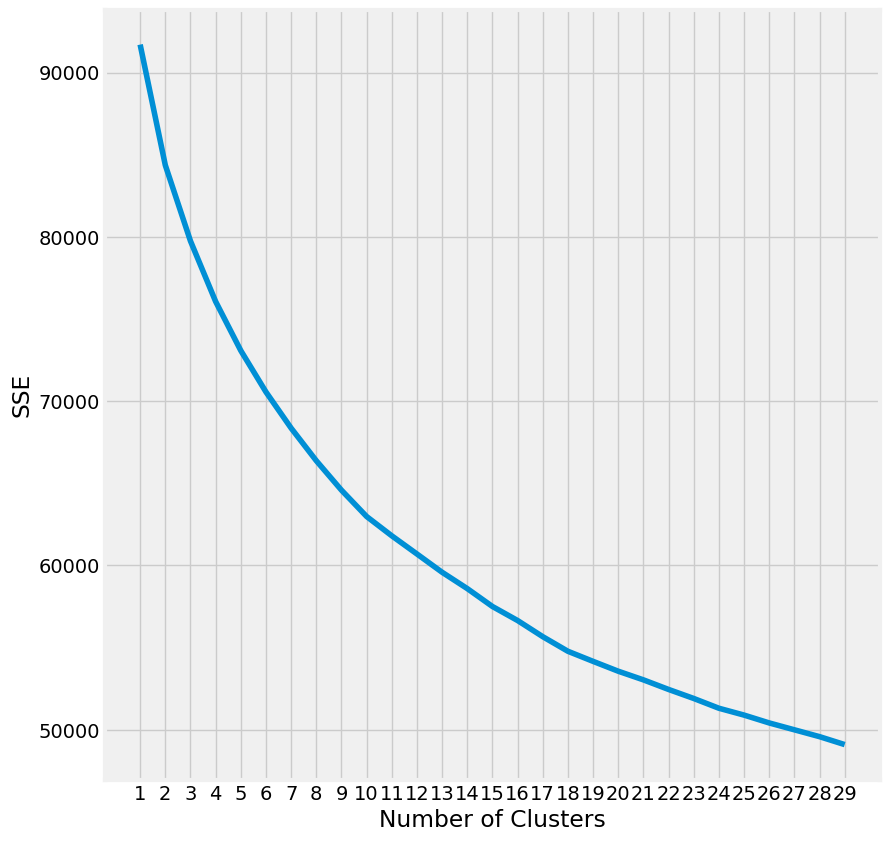

In [6]:

###################################################################
## K-MEANS
###################################################################
print('\n-----------------k-means--------------\n')
kmeans_kwargs = {"init": "random","n_init": 10,"max_iter": 300,"random_state": 42}
# A list holds the SSE values for each k
sse = []
for k in range(1, 30):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(data)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(5,5))
plt.style.use("fivethirtyeight")
plt.plot(range(1, 30), sse)
plt.xticks(range(1, 30))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.savefig('./data_house/kmeans.png')

kl = KneeLocator(range(1, 30), sse, curve="convex", direction="decreasing")

print('knee elbow: ',kl.elbow)
   
kmeans = KMeans(init="random", n_clusters=kl.elbow, n_init=10, max_iter=300,random_state=42)
kmeans.fit(data)
print('labels k-means: ', np.unique(kmeans.labels_))
n_clusters_kmeans = len(set(kmeans.labels_)) - (1 if -1 in kmeans.labels_ else 0)
print('n_clusters for kmeans: ', n_clusters_kmeans)

C:\Users\elsal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\elsal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


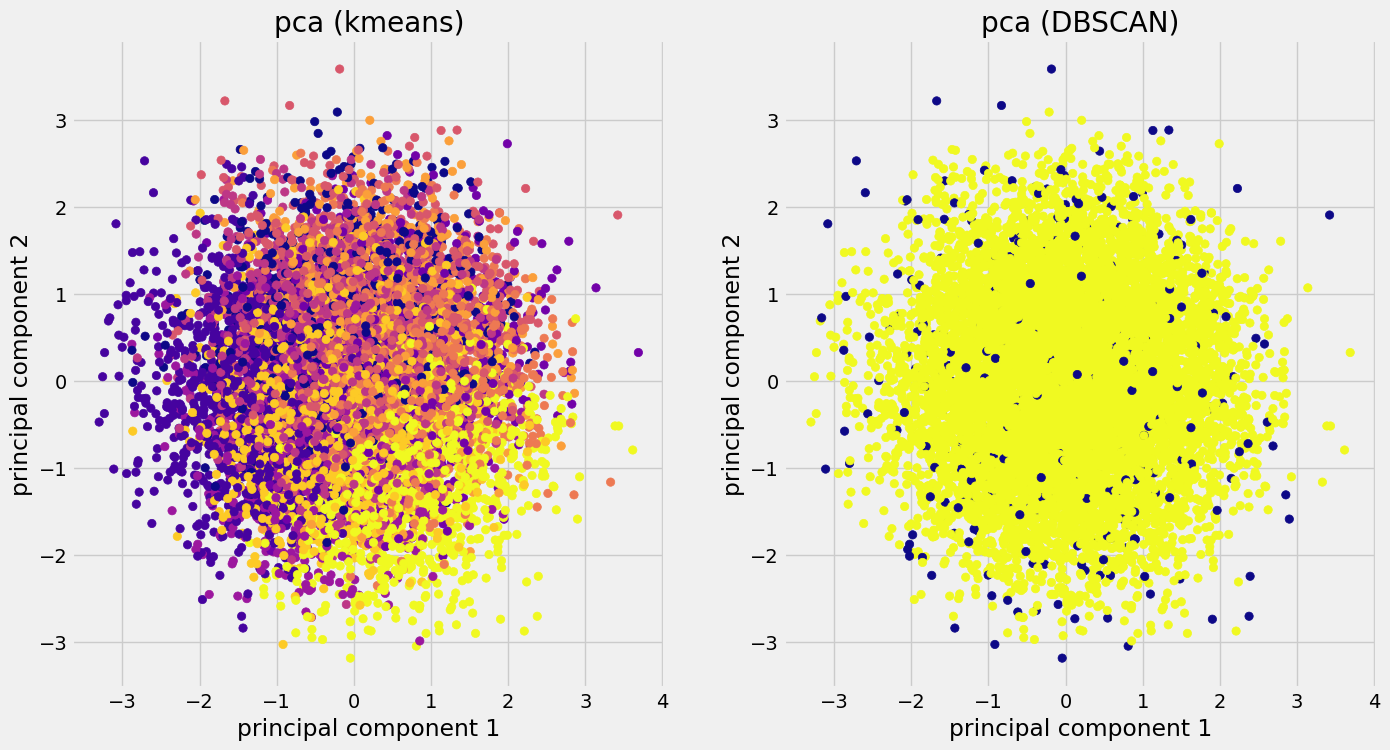

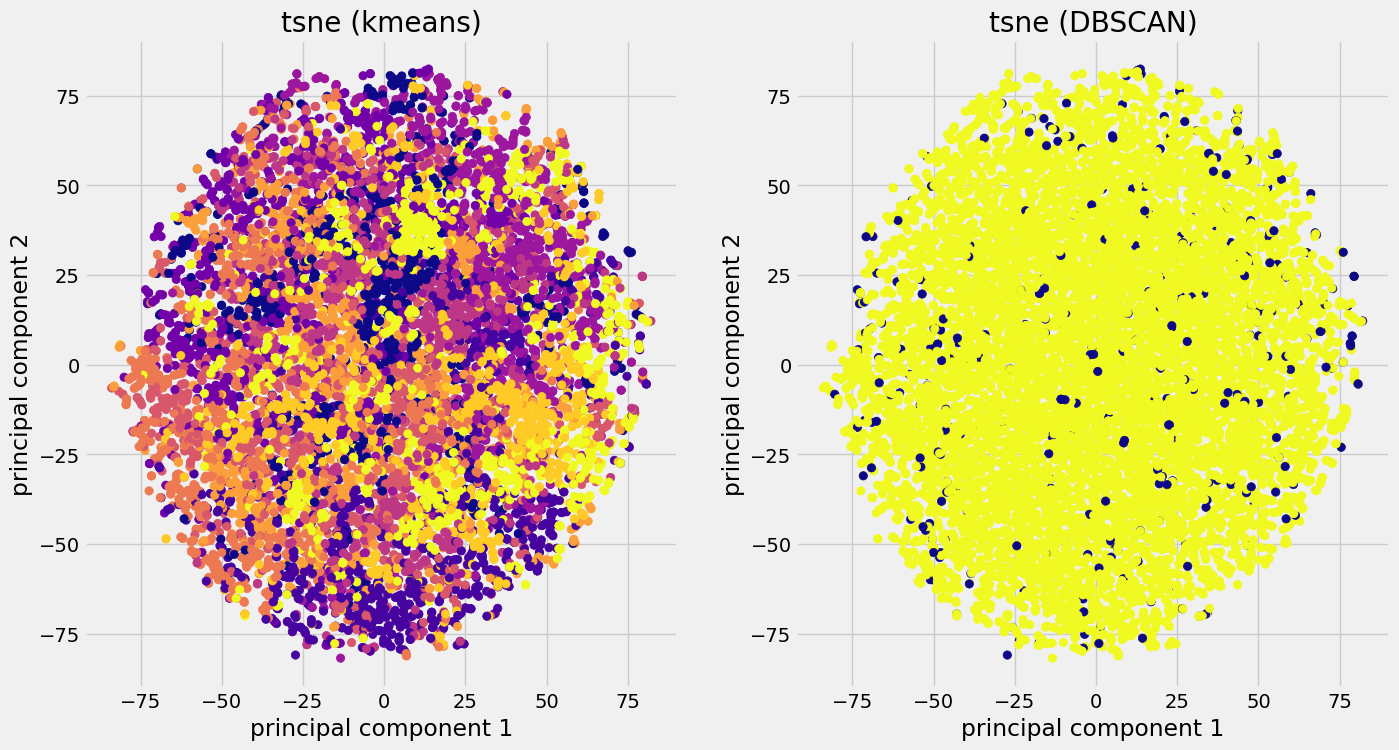

In [7]:

###################################################################
## Plot
###################################################################


if data.shape[1] != 2:  
    ###################################################################
    ## PCA
    ###################################################################

    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(data_normal)
    principalDf = pd.DataFrame(data = principalComponents
                , columns = ['principal component 1', 'principal component 2'])
    principalDf['color'] = kmeans.labels_
    
    

    plt.figure(figsize=(8,5)
    plt.subplot(1,2,1)
    plt.scatter(principalComponents[:,0], principalComponents[:,1], c=kmeans.labels_, cmap= "plasma") 
    plt.xlabel('principal component 1')
    plt.ylabel('principal component 2')
    plt.title('pca (kmeans)')
    
    plt.subplot(1,2,2)
    plt.scatter(principalComponents[:,0], principalComponents[:,1], c=labels, cmap= "plasma") 
    plt.xlabel('principal component 1')
    plt.ylabel('principal component 2')
    plt.title('pca (DBSCAN)')
    plt.savefig('./data_house/figure_dbsacn_pca') # showing the plot


    ###################################################################
    ## TSNE
    ###################################################################

    n_components = 2
    tsne = TSNE(n_components)
    tsne_result = tsne.fit_transform(data_normal)
    tsne_result.shape
    
    plt.figure(figsize=(8,5))
    plt.subplot(1,2,1)
    plt.scatter(tsne_result[:,0], tsne_result[:,1], c=kmeans.labels_, cmap= "plasma") 
    plt.xlabel('principal component 1')
    plt.ylabel('principal component 2')
    plt.title('tsne (kmeans)')
    

    plt.subplot(1,2,2)
    plt.scatter(tsne_result[:,0], tsne_result[:,1], c=labels, cmap= "plasma") 
    plt.xlabel('principal component 1')
    plt.ylabel('principal component 2')
    plt.title('tsne (DBSCAN)')

    
    plt.savefig('./data_house/figure_dbsacn_tsne')
else:
    plt.figure(figsize=(8,5))
    plt.subplot(1,2,1)
    plt.scatter(data[:,0], data[:,1], c=kmeans.labels_, cmap= "plasma") 
    plt.xlabel('principal component 1')
    plt.ylabel('principal component 2')
    plt.title('kmeans')
    
    plt.subplot(1,2,2)
    plt.scatter(data[:,0], data[:,1], c=labels, cmap= "plasma") 
    plt.xlabel('principal component 1')
    plt.ylabel('principal component 2')
    plt.title('DBSCAN')
    
    plt.savefig('./data_house/figure_dbsacn') # showing the plot

In [8]:

###################################################################
## Assign queries to clusters
###################################################################

queries =  pd.read_csv("./data_house/queries_to_use.csv", sep = ',', index_col = 0)
data = pd.read_csv("./data_house/database.csv", sep = ',') 
data['cluster_id_kmeans'] = kmeans.labels_
data['cluster_id_dbscan'] = labels
#print(data.head())

column_names_queries = queries.columns
#print(column_names_queries)

# We create an empty dataframe where we are going to store the matching outputs
columns_matching = [str(i) for i in np.unique(kmeans.labels_)]
matching_outputs = pd.DataFrame(0, index = range(len(queries)), columns=columns_matching)

for i in range(len(queries)):
    #print(queries.iloc[i])
    # We generate the condition
    condition = ""
    for j in range(1,n):
        if np.isnan(queries.iloc[i][j]):
            continue
        else:
            condition = condition + column_names_queries[j] + " == " + str(int(queries.iloc[i][j])) + ' and '
    condition = condition[:-4]
    #print(condition)
            
    matching = data.query(str(condition))
    #print(matching.index)
    
    for k in range(len(matching)):
        label_id = data['cluster_id_kmeans'].iloc[k]
        #print(label_id)
        matching_outputs[str(label_id)].iloc[i] += 1
    

#print(matching_outputs[:10])    
matching_outputs.to_csv('data_house/matching_outputs.csv', header = False, sep = ',', index=False)
maxValueIndex = matching_outputs.idxmax(axis = 1)
queries['kmeans_label_id'] = maxValueIndex


print('-------------queries-----------\n')
print("Used clusters: ", np.unique(queries['kmeans_label_id']))
event_counts = collections.Counter(queries['kmeans_label_id'])
import pprint
pprint.pprint(event_counts)

print('-------------database-----------\n')
print("Database: ", np.unique(data['cluster_id_kmeans']))
event_counts = collections.Counter(data['cluster_id_kmeans'])
import pprint
pprint.pprint(event_counts)

-------------queries-----------

Used clusters:  ['0' '2' '3' '5' '6' '7' '8']
Counter({'7': 501, '2': 429, '0': 378, '8': 303, '6': 261, '5': 95, '3': 33})
-------------database-----------

Database:  [0 1 2 3 4 5 6 7 8 9]
Counter({6: 1070,
         9: 1058,
         3: 1027,
         1: 1019,
         8: 993,
         2: 982,
         4: 979,
         0: 973,
         7: 952,
         5: 947})


In [18]:
###################################################################
## Jaccard similarity between queries
###################################################################
print('--------------jaccard similarity-----------\n')
# Create the set for each query
#print(column_names_queries)
dict_queries = {}
for i in range(len(queries)):
    set_query = []
    for j in range(1, len(queries.columns)-1):
        if np.isnan(queries.iloc[i][j]):
            continue
        else:
            for k in range(int(queries.iloc[i][j])):
                set_query.append(column_names_queries[j])
    dict_queries.update( {str(queries['query_id'].iloc[i]) : set_query} )

#print(dict_queries)
for i in range(10):
    print(dict_queries[str(i)])


--------------jaccard similarity-----------

['nrooms', 'nrooms', 'floors', 'floors', 'floors', 'gargae_sm', 'gargae_sm', 'gargae_sm', 'gargae_sm', 'year']
['price', 'price', 'price', 'price', 'price', 'price', 'price', 'price', 'price', 'price', 'price', 'price', 'price', 'price', 'price', 'price', 'price', 'price', 'price', 'price', 'price', 'price', 'price', 'price', 'price', 'price', 'price', 'price', 'price', 'price', 'price', 'price', 'price', 'price', 'price']
['gargae_sm', 'gargae_sm', 'gargae_sm', 'gargae_sm', 'gargae_sm']
['nbath', 'sm', 'sm', 'sm', 'sm', 'sm', 'sm', 'sm', 'sm', 'sm', 'sm', 'sm', 'sm', 'sm', 'sm', 'sm', 'sm', 'sm', 'sm']
['floors', 'price', 'price', 'price', 'price', 'price', 'price', 'price', 'price', 'price', 'price', 'price', 'price', 'price', 'price', 'price', 'price', 'price', 'price', 'price', 'price', 'price', 'price', 'price', 'price', 'price', 'price', 'dist_city', 'dist_city', 'dist_city', 'dist_city', 'dist_city', 'dist_city', 'dist_city', 'dist_ci

In [45]:
import json
with open("./data_house/query_set.json", "w") as outfile:
    json.dump(dict_queries, outfile)

In [118]:
user_queries =  pd.read_csv("./data_house/user_queries.csv", sep = ',')
recomendations_index = pd.DataFrame(0, index = range(len(user_queries)), columns =['user_id','top1', 'top2', 'top3', 'top4', 'top5'])
recomendations_value = pd.DataFrame(0, index = range(len(user_queries)), columns =['user_id','top1', 'top2', 'top3', 'top4', 'top5'])

for i in range(len(user_queries)):
    gvn_jsonfile = open("./data_house/query_set.json")
    json_data = json.load(gvn_jsonfile)
    
    #user_queries =  pd.read_csv("./data_house/user_queries.csv", sep = ',')
    print("---------------user {}------------\n ".format(i))
    dict_cluster = {}
    average_cluster = {}
    user_queries_non_nan = []
    user_queries_nan = []
    
    # We create lists containing the indexes of no ranked queries and ranked queries
    count = 0
    for t,j in user_queries.iloc[i][1:].items():           
      if (np.isnan(j)):
          user_queries_nan.append(t)
      else:
          user_queries_non_nan.append(t)

    # Create a dictionary
    for j in range(len(np.unique(queries['kmeans_label_id']))):
        dict_cluster.update({str(np.unique(queries['kmeans_label_id'])[j]) : []})
        average_cluster.update({str(np.unique(queries['kmeans_label_id'])[j]) : []})
    
    for k in range(len(user_queries_non_nan)):
        dict_cluster[str(queries['kmeans_label_id'].iloc[k])].append(user_queries_non_nan[k])
            
    #print(dict_cluster)
    
    # We calculate the average ranking of ranked queries in each cluster
    for j in range(len(np.unique(queries['kmeans_label_id']))):
        key = str(np.unique(queries['kmeans_label_id'])[j])
        ranking_temp = []
        for query_id in dict_cluster[key]:
            ranking_temp.append(user_queries[str(query_id)].iloc[i])
    
        average_cluster[key].append(sum(ranking_temp)/len(ranking_temp))
    #print('average rankings: ',average_cluster)
         
    #print(dict_queries)
    index_top_ranking = [0,0,0,0,0]
    value_top_ranking = [0,0,0,0,0]

    for item in user_queries_nan:
        set_query_nan = json_data[str(item)]
        
        key = str(queries['kmeans_label_id'].iloc[int(item)])
        similarity = []
        index_top_3 = [0,0,0]
        value_top_3 =[0,0,0]
                
        for query_id in dict_cluster[key]:
            set_query_non_nan = json_data[str(query_id)]
            
            
            similarity_value = jaccard_similarity(set_query_non_nan, set_query_nan)
            # similarity.append(similarity_value)
            if similarity_value > min(value_top_3):
                min_index = value_top_3.index(min(value_top_3))
                index_top_3[min_index] = int(query_id)
                value_top_3[min_index] = similarity_value 
        
        # Fill the ranking of the current nan query for the current user by averaging the top 3 values
        #print('query id: ', item)
        # Edge case if all top 3 are 0 average of all queries in a given cluster instead for ranking
        if all([val == 0 for val in index_top_3]):
            #print('we are in case 1\n')
            ranking = round(average_cluster[key][0],2)
            user_queries.at[i, str(item)] = ranking
    
    
        # Weighted ranking based on similarity score of top 3!
        elif all([val != 0 for val in index_top_3]):
            #print('we are in case 2\n')
            rankings = [int(user_queries[str(index_top_3[j])].iloc[i]) for j in range(len(index_top_3))]
            ranking = round(np.average(rankings, weights = value_top_3),2)
            user_queries.at[i, str(item)] = ranking
        
                  
        # Edge case if some of the top 3 are 0, don't use them!
        else:
            #print('we are in case 3\n')
            while 0 in index_top_3:
                index = index_top_3.index(0)
                value_top_3.pop(index)
                index_top_3.pop(index)
            
            rankings = [int(user_queries[str(index_top_3[j])].iloc[i]) for j in range(len(index_top_3))]
            if len(index_top_3) == 2:
                ranking = round(np.average(rankings, weights = value_top_3),2)
            else:
                ranking = rankings[0]
            user_queries.at[i, str(item)] = ranking
        
        
        
        min_value = min(value_top_ranking) 
        if ranking > min_value:
            min_index_ranking = value_top_ranking.index(min(value_top_ranking))
            index_top_ranking[min_index_ranking] = int(item)
            value_top_ranking[min_index_ranking] =  float(ranking)
        
        #print(user_queries.iloc[i][int(item)])
        
        
        
    # Return top k queries which were previously nan and now have a high rating
    #print('Any left nan values: ', user_queries.iloc[i].hasnans)
    #print("Reccommended queries for user {}: {} .".format(user_queries['user_id'].iloc[i], sort_by_indexes(index_top_ranking, value_top_ranking, True)))
    
    # Write in the dataframe 
    recomendations_index.iloc[i] = [user_queries['user_id'].iloc[i]] + sort_by_indexes(index_top_ranking, value_top_ranking, True)
    value_top_ranking.sort(reverse = True)
    recomendations_value.iloc[i] = [user_queries['user_id'].iloc[i]] + value_top_ranking
    #print(user_queries.iloc[i])

    
recomendations_index.to_csv("./data_house/recomendations_index.csv", sep = ',', header = True, index = False)
recomendations_value.to_csv("./data_house/recomendations_value.csv", sep = ',', header = True, index = False)

---------------user 0------------
 
[7, 0, 0]
[6]
[9, 0, 0]
[12]
[20, 82, 0]
[41, 0, 0]
[46]
[33, 0, 0]
[23]
[33, 0, 0]
[23]
[131, 0, 0]
[22]
[41, 103, 0]
[20, 82, 0]
[7, 0, 0]
[6]
[20, 82, 0]
[41, 0, 0]
[46]
[9, 0, 0]
[12]
[33, 0, 0]
[23]
[24, 90, 0]
[7, 0, 0]
[6]
[30, 131, 0]
[9, 53, 0]
[20, 82, 0]
[131, 0, 0]
[22]
[9, 0, 0]
[12]
[29, 0, 0]
[47]
[7, 0, 0]
[6]
[30, 131, 0]
[41, 103, 0]
[24, 90, 0]
[131, 0, 0]
[22]
[7, 0, 0]
[6]
[9, 0, 0]
[12]
[82, 114, 0]
[41, 82, 0]
[24, 90, 0]
[9, 0, 0]
[12]
[33, 0, 0]
[23]
[30, 0, 0]
[31]
[7, 82, 0]
[33, 0, 0]
[23]
[20, 0, 0]
[11]
[7, 82, 0]
[24, 90, 0]
[30, 131, 0]
[4, 14, 0]
[30, 0, 0]
[31]
[20, 82, 0]
[24, 132, 0]
[30, 131, 0]
[128, 132, 0]
[29, 54, 0]
[9, 0, 0]
[12]
[7, 0, 0]
[6]
[30, 0, 0]
[31]
[30, 33, 0]
[114, 0, 0]
[15]
[7, 0, 0]
[6]
[131, 0, 0]
[22]
[131, 0, 0]
[22]
[24, 0, 0]
[30]
[7, 87, 0]
[131, 0, 0]
[22]
[20, 82, 0]
[7, 0, 0]
[6]
[33, 0, 0]
[23]
[7, 0, 0]
[6]
[33, 0, 0]
[23]
[24, 188, 0]
[9, 0, 0]
[12]
[33, 0, 0]
[23]
[90, 0, 0]
[42]


In [119]:
###################################################################
## Fill out utility matrix
###################################################################

user_queries.to_csv('./data_house/user_queries_fill.csv', header = True, sep = ',', index = False)
user_queries_v2 =  pd.read_csv("./data_house/user_queries_fill.csv", sep = ',')
print(user_queries)

        user_id      0      1      2      3      4      5      6      7  \
0   622-47-5757  16.58   6.00  12.00  10.48   7.00  27.96  46.00   6.00   
1   754-30-0085  43.49  47.92  32.00  46.48  50.64  55.04  42.00  45.25   
2   179-83-5502  49.00  42.00  19.00  14.27  31.00  23.64  20.42  42.00   
3   670-94-7179  61.88  85.00  90.00  57.61  78.40  11.92  12.00  61.00   
4   641-17-3786  36.00   4.00  29.60  31.13  38.23  30.09  59.00  59.74   
..          ...    ...    ...    ...    ...    ...    ...    ...    ...   
95  153-27-5811  41.60  75.00  32.73  64.87  53.12  49.97  74.00  75.00   
96  843-17-7917  38.00  57.13  52.00  45.40  51.94  49.66  34.00  40.00   
97  333-20-1345  32.39  37.00  13.10  35.57  31.00  12.00  18.63  16.00   
98  732-10-8959  49.63  63.22  50.29  71.55  36.00  76.00  76.00  36.56   
99  707-13-9748  78.00   7.00  22.00   7.35  93.91  23.24  98.00  66.00   

        8  ...   1990   1991   1992   1993   1994   1995   1996   1997   1998  \
0   40.65  ...   6